# NYC OpenData Presentation

---

## Crash Analytics

Team:
Anthony Zeimbekakis, Benjamin Campman, Ryan Schoenfeld

### Understanding the Data

The dataset we are using is the `Motor Vehicle Collisions - Crash` table from NYC OpenData. It contains crash event information from all police reported motor vehicle collisions in NYC. The data has been filtered to contain only crashes reported for the calendar year 2021.

- Crash event information from all police reported motor vehicle collisions in NYC
     - Filtered to contain only crashes reported for the calendar year 2021
     - 110,482 crashes reported in 2021
     - Useful columns:
         - CRASH DATE
         - CRASH TIME
         - BOROUGH
         - CONTRIBUTING VEHICLE FACTOR: Factors contributing to the collision for designated vehicle
             - Alcohol Involvement
             - Drive Inattention/Distraction
             - Unspecified
             - Etc.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

nyc_crash = pd.read_csv("../data/nyc_crash_2021.csv")
%config InlineBackend.figure_format = 'svg'
import warnings
warnings.filterwarnings('ignore')

### What are the most common crash times in each borough?

In [2]:
from plotnine import *

nyc_crash["hour"] = [x.split(":")[0] for x in nyc_crash["CRASH TIME"]]
nyc_crash["hour"] = [int(x) for x in nyc_crash["hour"]]

It appears that the most crashes happen around 4-6pm, and the least crashes around 3am.

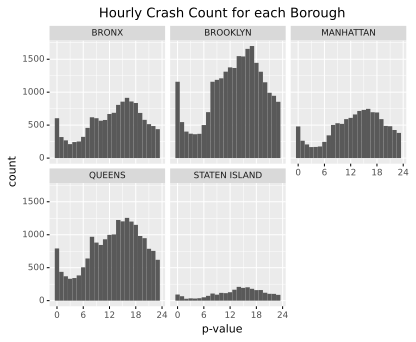

<ggplot: (8790604390647)>

In [3]:
(
    ggplot(nyc_crash[nyc_crash["BOROUGH"].notna()], aes(x = 'hour', y = after_stat('count')))
    + geom_histogram(bins = 24)
    + scale_x_continuous(name = "p-value", breaks = [0, 6, 12, 18, 24])
    + facet_wrap("BOROUGH")
    + ggtitle("Hourly Crash Count for each Borough")
)

In [4]:
nyc_crash["num_injured"] = nyc_crash["NUMBER OF PEDESTRIANS INJURED"]
nyc_crash["num_injured"] += nyc_crash["NUMBER OF CYCLIST INJURED"]
nyc_crash["num_injured"] += nyc_crash["NUMBER OF MOTORIST INJURED"]

def injury(row):
    if row["num_injured"] >= 1:
        val = 1
    else:
        val = 0
    return val

nyc_crash['injury'] = nyc_crash.apply(injury, axis = 1)

tab_injury = pd.crosstab(nyc_crash['injury'], nyc_crash['BOROUGH'])
tab_injury

BOROUGH,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
injury,,,,,
0,9317,16929,7764,13489,1872
1,4065,8225,3654,6067,792


In [5]:
def seasons(row):
    if row['CRASH DATE'] < "03/20/2021":
        val = "Winter"
    elif row['CRASH DATE'] < "06/21/2021":
        val = "Spring"
    elif row['CRASH DATE'] < "09/23/2021":
        val = "Summer"
    elif row['CRASH DATE'] < "12/21/2021":
        val = "Autumn"
    else:
        val = "Winter"
    return val

nyc_crash['Season'] = nyc_crash.apply(seasons, axis = 1)
nyc_crash['Season'].value_counts()

Summer    30653
Spring    29379
Autumn    28249
Winter    22201
Name: Season, dtype: int64

In [6]:
nyc_crash["CONTRIBUTING FACTOR VEHICLE 1"] = nyc_crash["CONTRIBUTING FACTOR VEHICLE 1"].fillna('Other')
df = nyc_crash["CONTRIBUTING FACTOR VEHICLE 1"].value_counts()

def cfv1_1000(row):
    if df[row['CONTRIBUTING FACTOR VEHICLE 1']] > 1000:
        val = row['CONTRIBUTING FACTOR VEHICLE 1']
    else:
        val = "Other"
    return val

nyc_crash['cfv1_1000'] = nyc_crash.apply(cfv1_1000, axis = 1)

tab = pd.crosstab(nyc_crash["cfv1_1000"], nyc_crash["num_injured"].sort_values(ascending=False))
tab

num_injured,0,1,2,3,4,5,6,7,8,9,10,11,14,16,17,18
cfv1_1000,,,,,,,,,,,,,,,,
Alcohol Involvement,1145,386,118,48,13,5,3,1,1,0,0,0,0,0,0,0
Backing Unsafely,2909,537,51,5,5,3,1,0,0,0,0,0,0,0,0,0
Driver Inattention/Distraction,17215,7280,1340,434,140,56,17,7,4,1,1,0,0,0,0,0
Driver Inexperience,1476,522,128,42,9,3,2,0,0,1,0,0,0,1,0,1
Failure to Yield Right-of-Way,3185,3463,535,136,55,8,5,4,1,0,1,0,0,0,0,0
Following Too Closely,4458,1973,579,176,58,24,6,4,0,2,1,0,0,0,1,0
Other,4808,3068,444,133,46,16,9,3,0,0,1,1,0,0,0,0
Other Vehicular,2206,599,172,66,16,9,3,1,0,0,0,0,0,0,0,0
Passing Too Closely,3911,320,49,13,3,0,0,1,0,0,0,0,0,0,0,0


### What is the percentage of death in each borough?

In [7]:
nyc_crash["num_killed"] = nyc_crash["NUMBER OF PEDESTRIANS KILLED"]
nyc_crash["num_killed"] += nyc_crash["NUMBER OF CYCLIST KILLED"]
nyc_crash["num_killed"] += nyc_crash["NUMBER OF MOTORIST KILLED"]

def death(row):
    if row["num_killed"] >= 1:
        val = 1
    else:
        val = 0
    return val

nyc_crash['death'] = nyc_crash.apply(death, axis = 1)

tab_death = pd.crosstab(nyc_crash["death"], nyc_crash["BOROUGH"])
tab_death

BOROUGH,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
death,,,,,
0,13363,25104,11394,19526,2659
1,19,50,24,30,5


### What is the percentage of injury in each borough?

* We can create a heatmap to visualize if someone was injured or not by borough
* We see that the numbers are similar from each borough with a little over two-thirds of crashes involving no injury

<AxesSubplot:xlabel='injury', ylabel='BOROUGH'>

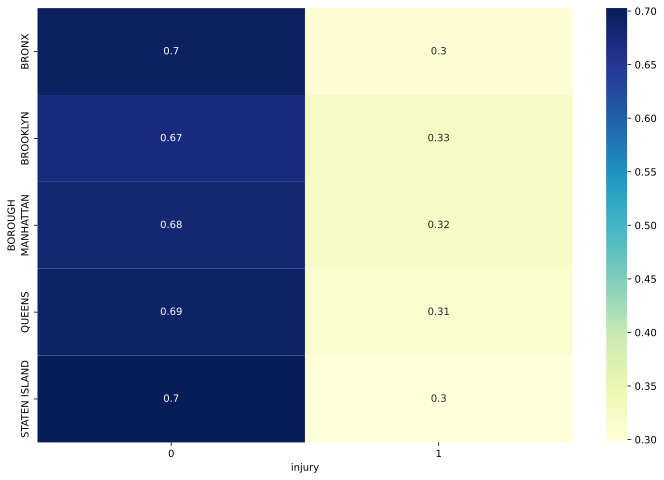

In [8]:
tab_perc = pd.crosstab(nyc_crash["BOROUGH"], nyc_crash["injury"], normalize = 'index')

plt.figure(figsize=(12,8)) 
sns.heatmap(tab_perc, annot=True, cmap="YlGnBu")

# Chi-Squared Regession on Injuries by Borough

In [9]:
import scipy.stats as stats
from scipy.stats import chisquare

tot_inj = tab_injury['BRONX'][1] + tab_injury["BROOKLYN"][1] + tab_injury["MANHATTAN"][1] + tab_injury["QUEENS"][1] + tab_injury["STATEN ISLAND"][1]
tot_crash = tab_injury['BRONX'][0] + tab_injury['BRONX'][1] + tab_injury["BROOKLYN"][0] + tab_injury["BROOKLYN"][1] + tab_injury["MANHATTAN"][0] + tab_injury["MANHATTAN"][1] + tab_injury["QUEENS"][0] + tab_injury["QUEENS"][1] + tab_injury["STATEN ISLAND"][0] + tab_injury["STATEN ISLAND"][1]

bronx_crash_perc = (tab_injury['BRONX'][0] + tab_injury['BRONX'][1]) / tot_crash
exp_bronx = round(tot_inj * bronx_crash_perc)

brook_crash_perc = (tab_injury["BROOKLYN"][0] + tab_injury["BROOKLYN"][1]) / tot_crash
exp_brook = round(tot_inj * brook_crash_perc)

manhat_crash_perc = (tab_injury["MANHATTAN"][0] + tab_injury["MANHATTAN"][1]) / tot_crash
exp_manhat = round(tot_inj * manhat_crash_perc)

queens_crash_perc = (tab_injury["QUEENS"][0] + tab_injury["QUEENS"][1]) / tot_crash
exp_queens = round(tot_inj * queens_crash_perc)

staten_crash_perc = (tab_injury["STATEN ISLAND"][0] + tab_injury["STATEN ISLAND"][1]) / tot_crash
exp_staten = round(tot_inj * staten_crash_perc)

chisquare([tab_injury['BRONX'][1], tab_injury["BROOKLYN"][1], tab_injury["MANHATTAN"][1], tab_injury["QUEENS"][1], tab_injury["STATEN ISLAND"][1]], f_exp=[exp_bronx, exp_brook, exp_manhat, exp_queens, exp_staten])

Power_divergenceResult(statistic=21.620629694488876, pvalue=0.00023845223075947072)

### What's the number of vehicles per crash by borough?

In [10]:
nyc_crash["CONTRIBUTING FACTOR VEHICLE 2"] = nyc_crash["CONTRIBUTING FACTOR VEHICLE 2"].fillna('NaN')
nyc_crash["CONTRIBUTING FACTOR VEHICLE 3"] = nyc_crash["CONTRIBUTING FACTOR VEHICLE 3"].fillna('NaN')
nyc_crash["CONTRIBUTING FACTOR VEHICLE 4"] = nyc_crash["CONTRIBUTING FACTOR VEHICLE 4"].fillna('NaN')
nyc_crash["CONTRIBUTING FACTOR VEHICLE 5"] = nyc_crash["CONTRIBUTING FACTOR VEHICLE 5"].fillna('NaN')

def number_of_vehicles(row):
    if row["CONTRIBUTING FACTOR VEHICLE 5"] != 'NaN':
        val = 5
    elif row["CONTRIBUTING FACTOR VEHICLE 4"] != 'NaN':
        val = 4
    elif row["CONTRIBUTING FACTOR VEHICLE 3"] != 'NaN':
        val = 3
    elif row["CONTRIBUTING FACTOR VEHICLE 2"] != 'NaN':
        val = 2
    elif row["CONTRIBUTING FACTOR VEHICLE 1"] != 'NaN':
        val = 1
    return val

nyc_crash['num_vehicles'] = nyc_crash.apply(number_of_vehicles, axis = 1)

In [11]:
tab_vehicles = pd.crosstab(nyc_crash["BOROUGH"], nyc_crash["num_vehicles"], normalize='index')
round(tab_vehicles, 3)

num_vehicles,1,2,3,4,5
BOROUGH,,,,,
BRONX,0.283,0.628,0.063,0.017,0.009
BROOKLYN,0.231,0.665,0.071,0.022,0.012
MANHATTAN,0.245,0.700,0.041,0.009,0.004
QUEENS,0.224,0.670,0.077,0.021,0.009
STATEN ISLAND,0.252,0.656,0.075,0.014,0.003


# Random Forest Model on Injury

In [12]:
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

### Cleaning the Data

* We need to change the data to a format to be able to run a predictive model on it
* The variables we are going to be using to predict an injury are the number of vehicles, timeframe, Borough and the reason for the crash

In [13]:
def timeframes(x):
    if x <= 5:
        return 1
    elif x > 5 and x <= 11:
        return 2
    elif x > 11 and x <= 17:
        return 3
    else:
        return 4
    

## Take crash hours and put them into specifc intervals
nyc_crash['timeframe'] = nyc_crash['hour'].apply(timeframes)
nyc_crash['timeframe'] = nyc_crash['timeframe'].astype('category')

feature_cols = nyc_crash[['num_vehicles', 'Season','timeframe', 'BOROUGH', 'cfv1_1000']]
features = pd.get_dummies(feature_cols)
features.head()


,num_vehicles,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,timeframe_1,timeframe_2,timeframe_3,timeframe_4,BOROUGH_BRONX,...,cfv1_1000_Other,cfv1_1000_Other Vehicular,cfv1_1000_Passing Too Closely,cfv1_1000_Passing or Lane Usage Improper,cfv1_1000_Reaction to Uninvolved Vehicle,cfv1_1000_Traffic Control Disregarded,cfv1_1000_Turning Improperly,cfv1_1000_Unsafe Lane Changing,cfv1_1000_Unsafe Speed,cfv1_1000_Unspecified
0,2,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Creating the model

* We are going to be using a random forest model to make predictions
* A random forest model works by making many decision trees and taking the best aspects of them to make the best possible prediction

In [14]:
y = nyc_crash.injury

x_train, x_test, y_train, y_test = train_test_split(features, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

rfclf = RandomForestClassifier(n_estimators = 100, random_state = 3131)
rfclf = rfclf.fit(x_train, y_train)

y_pred = rfclf.predict(x_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.6909535231026837
[[13553  1229]
 [ 5600  1715]]


* We see that this model gives us an accuracy of about 69%
* Our model is able to accurately predict if someone was injured in 15349 of 22097 the test rows

In [15]:
for i in range (1, 11):
    rfclf = RandomForestClassifier(n_estimators = 100, random_state = 42, max_depth = i)
    rfclf = rfclf.fit(x_train, y_train)
    y_pred = rfclf.predict(x_test)
    print("Accuracy for Forest with Max Depth {i}:".format(i = i), 
          metrics.accuracy_score(y_test, y_pred))

Accuracy for Forest with Max Depth 1: 0.6689595872742906
Accuracy for Forest with Max Depth 2: 0.6689595872742906
Accuracy for Forest with Max Depth 3: 0.6800923202244649
Accuracy for Forest with Max Depth 4: 0.6828981309680047
Accuracy for Forest with Max Depth 5: 0.6828981309680047
Accuracy for Forest with Max Depth 6: 0.6829886409919899
Accuracy for Forest with Max Depth 7: 0.6863827668914332
Accuracy for Forest with Max Depth 8: 0.688555007467077
Accuracy for Forest with Max Depth 9: 0.6931257636783273
Accuracy for Forest with Max Depth 10: 0.6945286690500972


Text(0.5, 0, 'Relative Importance')

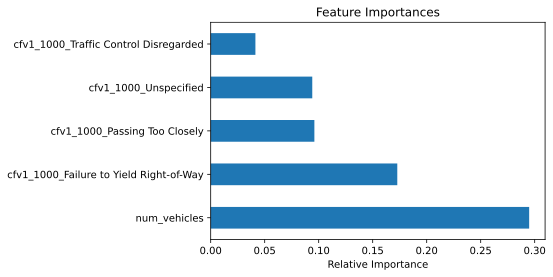

In [16]:
feat_importances = pd.Series(rfclf.feature_importances_, index=features.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Relative Importance')

* This graph shows us which of the variables we used are most important
* We see that the number or vehicles in the crash are the most important factor for seeing if someone was injured or not

# Support Vector Machine for Injury

In [17]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics

feature_cols = nyc_crash[['num_vehicles', 'Season','timeframe', 'BOROUGH', 'cfv1_1000']]
features = pd.get_dummies(feature_cols)

x_train, x_test, y_train, y_test = train_test_split(features, nyc_crash["injury"], test_size = 0.3, random_state=10)

clf = svm.SVC(kernel = 'linear')
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print('Accuracy:', metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6819429778247096


* Here we use a different type of model to predict if someone was injured or not
* We use the same input variables as the random forest model
* The SVM model gives us a similar accuracy to the random forest model but is slightly worse at predicting injury